## Imports

In [3]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from joblib import dump
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import *

from aqosd_experiments.config import *
from aqosd_experiments.data import *
from aqosd_experiments.utils import *
from aqosd_experiments.plot import *
from aqosd_experiments.scorers import *
from osms import OverheadSensitiveMetricSelection

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Load Config

In [4]:
save=True

## Load and prepare data

In [5]:
metrics, bottlenecks = import_and_prepare_data(RAW_DATASET_PATH,  HOST_LIST)
print('Shape of metrics : ',metrics.shape,'\t','Shape of bottlenecks : ',bottlenecks.shape)
print('Label cardinality = %.5f \t Label density = %.5f' % (bottlenecks.sum(axis=1).mean(),bottlenecks.mean(axis=1).mean()))

0 days 23:59:50 of Data
Shape of metrics :  (8640, 104) 	 Shape of bottlenecks :  (8640, 32)
Label cardinality = 1.96019 	 Label density = 0.06126


In [6]:
metric_names, bottleneck_names = list(metrics.columns), list(bottlenecks.columns)
print(metric_names)
print(100*'-')
print(bottleneck_names)

['SRV./: Free inodes in %', 'SRV./: Space utilization', 'SRV./: Used space', 'SRV./boot: Free inodes in %', 'SRV./boot: Space utilization', 'SRV./boot: Used space', 'SRV.Available memory', 'SRV.Available memory in %', 'SRV.CPU idle time', 'SRV.CPU iowait time', 'SRV.CPU softirq time', 'SRV.CPU system time', 'SRV.CPU user time', 'SRV.CPU utilization', 'SRV.Context switches per second', 'SRV.Free swap space', 'SRV.Free swap space in %', 'SRV.Interface enp0s8: Bits received', 'SRV.Interface enp0s8: Bits sent', 'SRV.Interrupts per second', 'SRV.Load average (15m avg)', 'SRV.Load average (1m avg)', 'SRV.Load average (5m avg)', 'SRV.Memory utilization', 'SRV.Number of processes', 'SRV.Number of running processes', 'GW1./: Free inodes in %', 'GW1./: Space utilization', 'GW1./: Used space', 'GW1./boot: Free inodes in %', 'GW1./boot: Space utilization', 'GW1./boot: Used space', 'GW1.Available memory', 'GW1.Available memory in %', 'GW1.CPU idle time', 'GW1.CPU iowait time', 'GW1.CPU softirq time

,CPU,Memory,Disk space,Disk I/O,Packet delay,Packet duplicate,Packet loss,Packet corrupt
Node,,,,,,,,
GW1,5.113368,3.790742,2.952291,2.798772,3.247520,2.131554,1.895371,1.895371
GW11,4.965753,4.369391,3.507322,2.627539,2.810581,2.385451,2.314596,2.456306
GW111,5.331838,3.920642,3.489608,2.739726,2.916863,2.355928,2.025272,2.479924
SRV,4.747284,4.174539,3.637222,2.993623,1.859943,2.668871,3.064478,2.332310


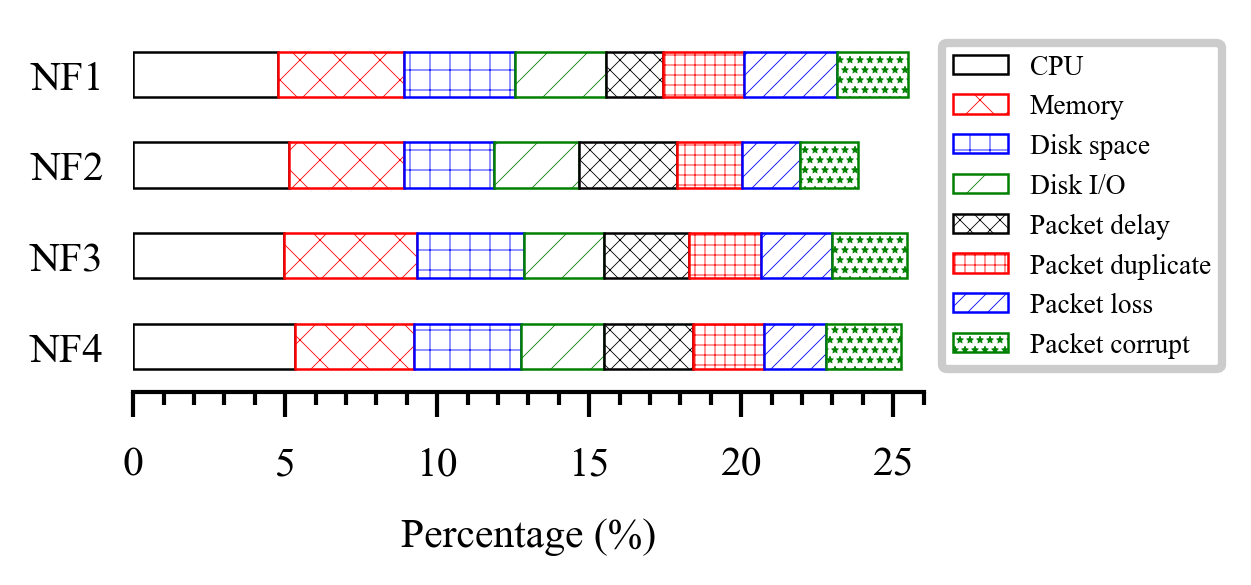

In [88]:
from itertools import cycle
from itertools import cycle
d=8
c = cycle(4*['k']+4*['r']+4*['b']+4*['g'])
mpl.rcParams['hatch.linewidth'] = 0.1 
h1, h2 = 10, 5
hatchs=cycle([h1*"*",h1*"/", h1*"+",h1*"x", h2*"/", h2*"+",h2*"x",""][::-1])
cols=['cpu','memory','diskspace','diskio','network delay','network packet duplicate','network packet loss',
      'network packet corrupt']#[::-1]
lab=['CPU','Memory','Disk space','Disk I/O','Packet delay','Packet duplicate','Packet loss','Packet corrupt']#[::-1]
def plot_number_of_instance(data):
    def offxy(ax):
        ax.grid(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax2 = ax.twiny()
        ax2.set_xticks([]), ax2.xaxis.set_ticklabels([])
        ax2.tick_params(axis='x', which='both', size=0)
        [ax2.spines[p].set_visible(False) for p in ['left', 'right', 'top', 'bottom']]
        ax2 = ax.twinx()
        ax2.set_yticks([]), ax2.yaxis.set_ticklabels([])
        [ax2.spines[p].set_visible(False) for p in ['left', 'right', 'top', 'bottom']]
        
    fig, ax = plt.subplots(figsize=(1.7,.8))
    df = data.melt(value_vars=data.columns)
    df = df[df["value"] != 0]
    df = 100 * df.variable.value_counts(normalize=True, ascending=False)
    df = df.to_frame()
    df.columns=['Percentage']
    df['bottleneck']=df.index
    df = df.reset_index(drop=True)
    df["Node"], df["Bottleneck"] = zip(*df["bottleneck"].str.split('.').tolist())
    del df["bottleneck"]
    df = df[['Node','Bottleneck', 'Percentage']]
    #display(df)
    df = df.groupby(['Node', 'Bottleneck','Percentage']).size().reset_index().pivot(columns='Bottleneck', index='Node', values='Percentage')
    df = df[cols]
    df.columns=lab
    display(df)
    df = df.reindex(["SRV", "GW1", "GW11","GW111"][::-1])
    df.plot.barh(ax=ax, color='w', edgecolor='k', lw=.3,stacked=True, rot=0,legend=False)
    [[(p.set_hatch(hatch), p.set_edgecolor(next(c))) for p in container.patches] for container, hatch in zip(ax.containers,hatchs)]
    ax.set_xlabel('Percentage (%)'), ax.set_ylabel('')
    ax.set_xticks(np.arange(0,26,5)), ax.xaxis.set_ticklabels(np.arange(0,26,5), fontsize=3.3)
    offxy(ax)
    ax.tick_params(axis='y', which='both', size=0), ax.tick_params(axis='x', which='both',direction ='out')
    [item.set_fontsize(5) for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels()  + ax.get_yticklabels())]
    ax.set_yticklabels(["NF1", "NF2", "NF3", "NF4"][::-1], ha='right')
    ax.set_xlim([None, 26])
    #ax.set_ylim([None, 7.5])
    ax.legend(ncol=1, loc='upper center', bbox_to_anchor=(1.2, 1), fontsize=3.3)
    
    return fig

fig = plot_number_of_instance(bottlenecks.copy())
fig.savefig(FIG_PATH + "Number_of_instance_with_a_class_label.pdf", bbox_inches='tight')

,Node,Bottleneck,Percentage
0,GW111,cpu,5.331838
1,GW1,cpu,5.113368
2,GW11,cpu,4.965753
3,SRV,cpu,4.747284
4,GW11,memory,4.369391
5,SRV,memory,4.174539
6,GW111,memory,3.920642
7,GW1,memory,3.790742
8,SRV,diskspace,3.637222
9,GW11,diskspace,3.507322


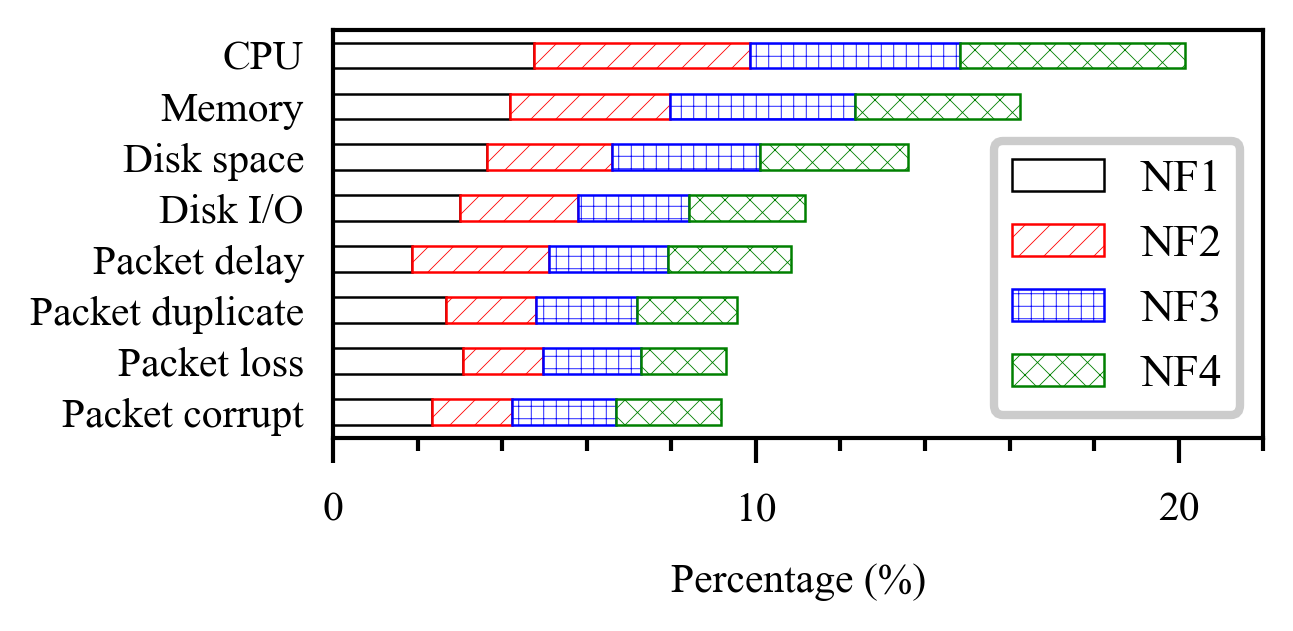

In [7]:
from itertools import cycle
d=8
c = cycle(d*['k']+d*['r']+d*['b']+ d*['g'])
mpl.rcParams['hatch.linewidth'] = 0.1 
h=8
hatchs=(" ",h*"/", h*"+",h*"x")
def plot_number_of_instance(data):
    def offxy(ax):
        ax.grid(False)
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
        ax2 = ax.twiny()
        ax2.set_xticks([]), ax2.xaxis.set_ticklabels([])
        ax2.tick_params(axis='x', which='both', size=0)
        [ax2.spines[p].set_visible(False) for p in ['left', 'right', 'top', 'bottom']]
        ax2 = ax.twinx()
        ax2.set_yticks([]), ax2.yaxis.set_ticklabels([])
        [ax2.spines[p].set_visible(False) for p in ['left', 'right', 'top', 'bottom']]
        
    fig, ax = plt.subplots(figsize=(2,.9))
    df = data.melt(value_vars=data.columns)
    df = df[df["value"] != 0]
    df = 100 * df.variable.value_counts(normalize=True, ascending=False)
    df = df.to_frame()
    df.columns=['Percentage']
    df['bottleneck']=df.index
    df = df.reset_index(drop=True)
    df["Node"], df["Bottleneck"] = zip(*df["bottleneck"].str.split('.').tolist())
    del df["bottleneck"]
    df = df[['Node','Bottleneck', 'Percentage']]
    display(df)
    df = df.groupby(['Node', 'Bottleneck','Percentage']).size().reset_index().pivot(columns='Node', index='Bottleneck', values='Percentage')
    df = df[['SRV', 'GW1', 'GW11', 'GW111']]
    df.columns=['NF1','NF2','NF3','NF4']
    #display(df)
    df = df.reindex(['cpu','memory','diskspace','diskio','network delay', 'network packet duplicate','network packet loss','network packet corrupt'][::-1])
    df.plot.barh(ax=ax, color='w', edgecolor='k', lw=.3,stacked=True, rot=0,legend=False)
    [[(p.set_hatch(hatch), p.set_edgecolor(next(c))) for p in container.patches] for container, hatch in zip(ax.containers,hatchs)]
    ax.set_xlabel('Percentage (%)'), ax.set_ylabel('')
    offxy(ax)
    ax.tick_params(axis='y', which='both', size=0), ax.tick_params(axis='x', which='both',direction ='out')
    [item.set_fontsize(5) for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels()  + ax.get_yticklabels())]
    ax.set_yticklabels(['CPU','Memory','Disk space','Disk I/O','Packet delay','Packet duplicate','Packet loss', 'Packet corrupt'][::-1], ha='right')
    ax.set_xlim([None, 22])
    #ax.set_ylim([None, 7.5])
    ax.legend(ncol=1, loc=4, fontsize=5.5)
    
    return fig

fig = plot_number_of_instance(bottlenecks.copy())
fig.savefig(FIG_PATH + "Number_of_instance_with_a_class_label.pdf", bbox_inches='tight')

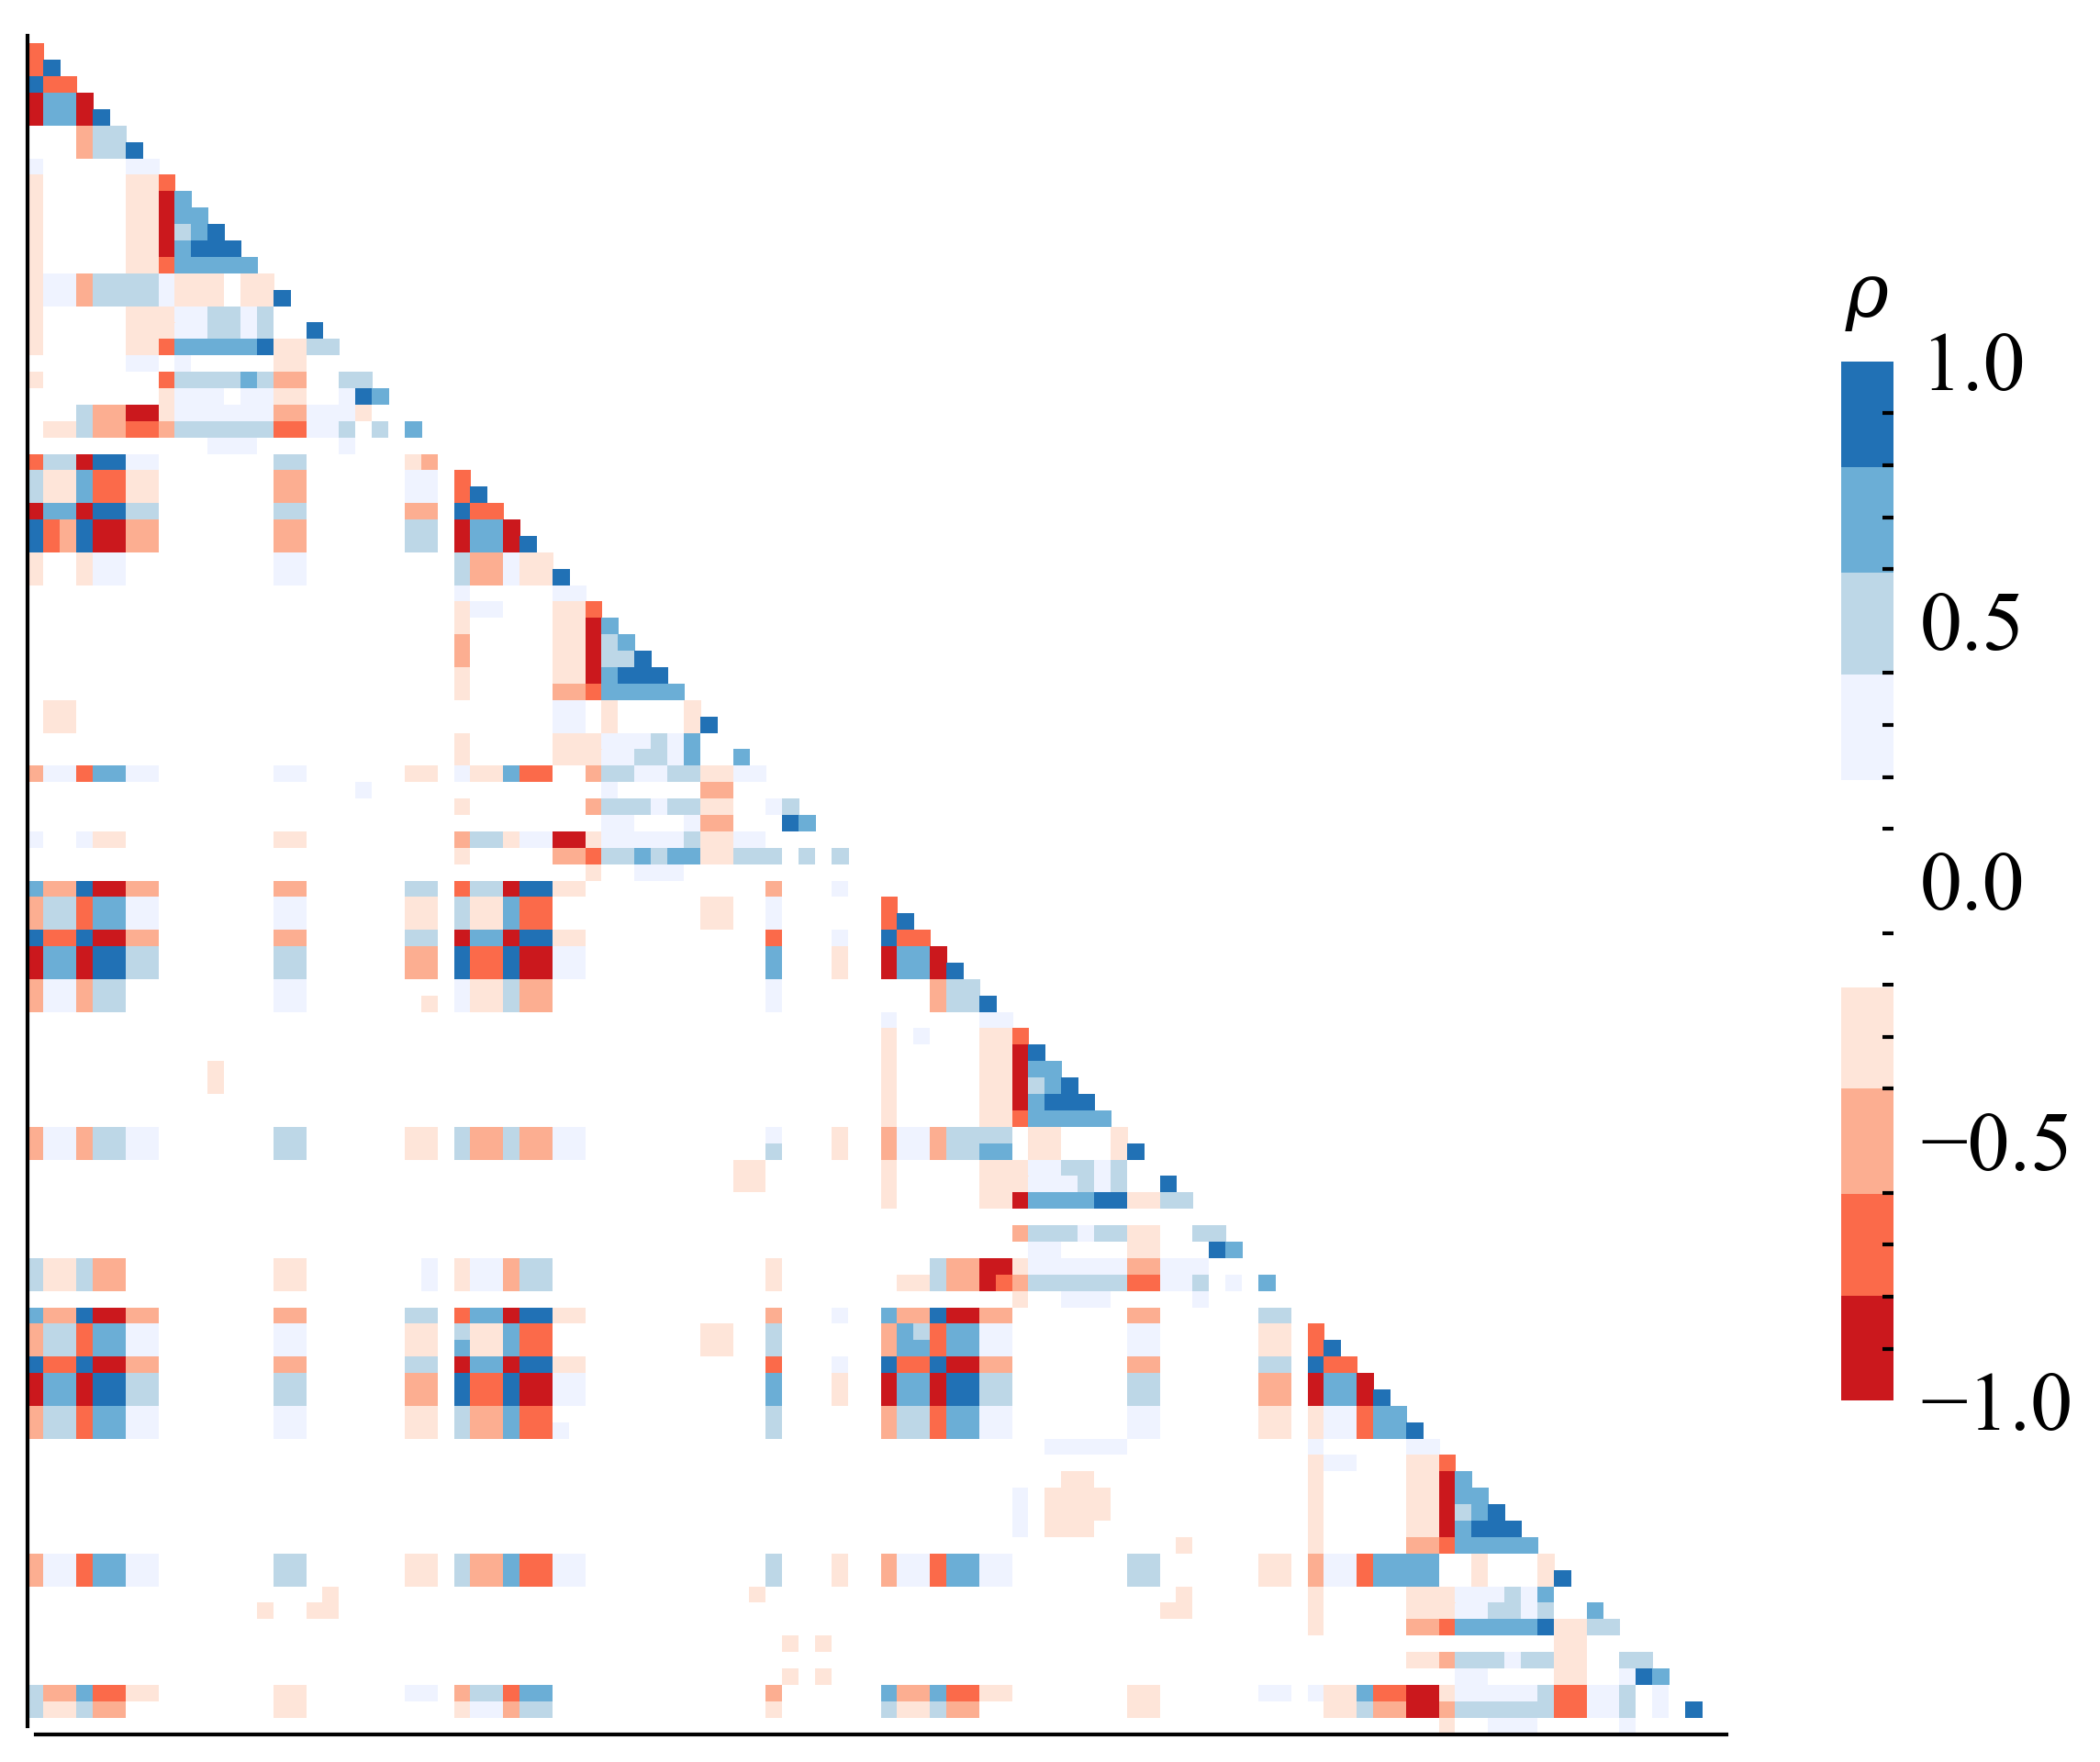

In [6]:
def plt_corr_metrics(data, c3='w', method='spearman'):
    fig, ax = plt.subplots( figsize=(5, 5))
    ax_bounds = .5, len(data.columns) - .5
    corr = data.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    ticks=np.arange(0,105)
    # .00-.19 “very weak” .20-.39 “weak” .40-.59 “moderate” .60-.79 “strong” .80-1.0 “very strong”
    colors = [c3, '#fee5d9', '#fcae91', '#fb6a4a', '#cb181d']
    cmap = mpl.colors.ListedColormap(colors[::-1] + [c3, '#eff3ff', '#bdd7e7', '#6baed6', '#2171b5'])
    sns.heatmap(corr, ax=ax, cmap=cmap, mask=mask, annot=False, vmin=-1, vmax=1, square=True, center=0,
                cbar_kws={"shrink": .5, 'spacing': 'proportional'})#, xticklabels=ticks, yticklabels=ticks)
    ax.collections[0].colorbar.ax.tick_params(size=0, labelsize=11)
    mpl.rcParams['text.usetex'] = True
    ax.collections[0].colorbar.ax.set_title(r'$\rho$')
    mpl.rcParams['text.usetex'] = False
    ax.spines['left'].set_visible(True), ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_bounds(ax_bounds), ax.spines['bottom'].set_bounds(ax_bounds)
    ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left'), ax.xaxis.set_ticks_position('bottom')
    plt.xticks([])
    plt.yticks([])
    [item.set_fontsize(2) for item in
    ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels())]
    return fig

fig = plt_corr_metrics(metrics)
if save:
    fig.savefig(FIG_PATH + "corrplot.pdf", bbox_inches='tight')